<img src="../img/ICHEC_Logo.png" alt="Drawing" style="width: 500px;"/>

<center> <img src="../img/Numba_Logo.png" alt="Drawing" style="width: 300px;"/>

# <center> [Numba](https://numba.pydata.org/) Introduction <center/>
******
***

Numba is a **just-in-time** compiler for Python functions. Numba can, from the types of the function arguments translate the function into a specialised, fast, machine code equivalent.

* Uses [LLVM](https://llvm.org/) compiler infrastructure  for code generation.
    
    
* Get speeds similar to C/C++ and fortran but without having to write any code in those languages, doesn't require C/C++ compiler.

* Simple as applying one of the Numba **decorators** to your Python function. A decorator is a function that takes in a function as an argument and spits out a function

    
* Designed to work well with NumPy arrays and is therefore very useful for **scientific computing**.
    

* Makes it easy to **parallelise** your code and use multiple threads.
    

* Does **SIMD vectorisation** to get most out of your CPU. Meaning a single instruction can be applied to multiple data elements in parallel. Numba automatically translate some loops into vector instructions and will adapt to your CPU capabilities automatically.
    

* Can run Numba code on GPU. (Not covering that in this course).

**“Numba” = “NumPy”+ “Mamba”**

# <center>Overview<center>   
***

* The jit decorator
    
* Compare Numba on Numpy and Python code
    
    
* Demonstrate modes 
    
    
* **Examples**
    * `cache=True`
    * Eager Compilation
    * `fastmath=True`
    * Parallelising 
    * Vectorising - ufuncs


In [1]:
#Importing the things we will need

import numpy as np

import math
import time

import numba
from numba import jit, njit

Check which version you have

In [2]:
#check version
print(numba.__version__)

0.55.1


***
# <center> The Jit compiler options/toggles<center> 

```python
@numba.jit(signature=None, nopython=False, nogil=False, cache=False, forceobj=False, parallel=False, 
           error_model='python', fastmath=False, locals={}, boundscheck=False)
```
* `signature` - The expected types and signatures of function arguments and return values - **Eager Compilation** 

* Numba has two **modes** - `nopython`, `forcobj`.  Numba will infer the argument types at call time, and generate optimized code based on this information.

*  `nogil=True` - releases the gil inside the compiled function - only if in `nopython` mode.

* `cache=True` - enables a file-based cache to shorten compilation times when the function was already compiled in a previous invocation. Cannot be used in conjunction with `parallel=True`.

* `parallel=True` - enables the automatic parallelization of a number of common Numpy constructs.

* `error_model` - controls the divide-by-zero behavior. Setting it to ‘python’ causes divide-by-zero to raise exception. Setting it to ‘numpy’ causes divide-by-zero to set the result to +/-inf or nan.

* `fastmath=True` - enables the use of otherwise unsafe floating point transforms as described in the LLVM documentation.

* `locals` dictionary - used to force the Types and signatures of particular local variables. Recommended to let Numba’s compiler infer the types of local variables by itself.

* `boundscheck=True` - enables bounds checking for array indices. Out of bounds accesses will raise IndexError. Enabling bounds checking will slow down typical functions, so it is recommended to only use this flag for debugging


***
# <center> Comparing Python and NumPy<center> 

In [10]:
#@jit
def pi_montecarlo_python(n):
    in_circle = 0
    for i in range(int(n)):
        x, y = np.random.random(), np.random.random()
        if x ** 2 + y ** 2 <= 1.0:
            in_circle += 1
        
    return 4.0 * in_circle / n

#@jit
def pi_montecarlo_numpy(n):
    in_circle = 0
    x = np.random.random(int(n))
    y = np.random.random(int(n))
    in_circle = np.sum((x ** 2 + y ** 2) <= 1.0)
        
    return 4.0 * in_circle / n

In [8]:
n = 1000

In [9]:
print('python')
%time pi_montecarlo_python(n)
print("")
print('numpy')
%time pi_montecarlo_numpy(n)

python
CPU times: user 596 µs, sys: 1.69 ms, total: 2.29 ms
Wall time: 31.4 ms

numpy
CPU times: user 548 µs, sys: 0 ns, total: 548 µs
Wall time: 557 µs


3.132

In [12]:
# add jit decorators
# notice compilation time

print('python jit')
%time pi_montecarlo_python(n)
print("")

print('numpy jit')
%time pi_montecarlo_numpy(n)

print("")
print('SECOND RUN')
print("")

print('python jit')
%time pi_montecarlo_python(n)
print("")

print('numpy jit')
%time pi_montecarlo_numpy(n)

python jit
CPU times: user 14 µs, sys: 11 µs, total: 25 µs
Wall time: 30.5 µs

numpy jit
CPU times: user 54 µs, sys: 0 ns, total: 54 µs
Wall time: 33.9 µs

SECOND RUN

python jit
CPU times: user 25 µs, sys: 0 ns, total: 25 µs
Wall time: 30.8 µs

numpy jit
CPU times: user 18 µs, sys: 13 µs, total: 31 µs
Wall time: 35 µs


3.156

- Once the compilation has taken place Numba caches the machine code version of the function for the **particular types** of arguments presented. Eg if we changed `n = 1000.0`

- To benchmark Numba-compiled functions, it is important to time them without including the compilation step - the compilation will only happen once for each set of input types, but the function will be called many times.

- By adding `@jit` decorator we see major speed ups for Python and a bit for NumPy. 

- This is where Numba is very useful - speeding up python loops that cannot be converted to NumPy or it's too complicated. NumPy can sometimes reduce readability. 

- Get huge speed ups with minimum effort.

- “Don’t write NumPy Haikus. If loops are simpler, write loops and use Numba!” Stan Seibert, Numba team, Anaconda


<img src="../img/fun.png" alt="Drawing" style="width: 700px;"/>


***
# <center> Demonstrating modes - `nopython = True`<center> 

In [13]:
def is_prime(n):
    if n <= 1:
        raise ArithmeticError('%s <= 1' %n)
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False

    return True

In [14]:
numbers = np.random.randint(2, 100000, size=10)

In [15]:
is_prime_jit = jit(is_prime)

In [17]:
# Purposeful Warning 
print("Pure Python")
%time p1 = [is_prime(x) for x in numbers]
print("")
print("Jitted including compilation")
%time p2 = [is_prime_jit(x) for x in numbers]
print("")
print("Jitted")
%time p2 = [is_prime_jit(x) for x in numbers]

# second run and warning is gone

Pure Python
CPU times: user 57 µs, sys: 35 µs, total: 92 µs
Wall time: 96.3 µs

Jitted including compilation
CPU times: user 28 µs, sys: 17 µs, total: 45 µs
Wall time: 49.1 µs

Jitted
CPU times: user 37 µs, sys: 0 ns, total: 37 µs
Wall time: 41 µs


In [18]:
is_prime_njit = jit(nopython=True)(is_prime)

In [19]:
# Purposeful Error
print("Pure Python")
%time p1 = [is_prime(x) for x in numbers]
print("")
print("Njitted including compilation")
%time p2 = [is_prime_njit(x) for x in numbers]
# Go back and change to raise ArithmeticError('n <= 1')
print("")
print("Njitted")
%time p2 = [is_prime_njit(x) for x in numbers]

Pure Python
CPU times: user 57 µs, sys: 35 µs, total: 92 µs
Wall time: 96.3 µs

Njitted including compilation


ConstantInferenceError: Failed in nopython mode pipeline (step: nopython rewrites)
Constant inference not possible for: $const12.1 % n

File "../../../../../../../tmp/ipykernel_16140/4151855512.py", line 3:
<source missing, REPL/exec in use?>



Njitted


ConstantInferenceError: Failed in nopython mode pipeline (step: nopython rewrites)
Constant inference not possible for: $const12.1 % n

File "../../../../../../../tmp/ipykernel_16140/4151855512.py", line 3:
<source missing, REPL/exec in use?>


***
# <center> Explaing `nopython=True` mode<center> 

`@jit(nopython=True)` is equivalent to `@njit` 

* The behaviour of the nopython compilation mode is to essentially compile the decorated function so that it will run entirely **without** the involvement of the **Python interpreter**.

* If it can't do that an exception is raised. These exceptions usually indicate places in the function that need to be modified in order to achieve better-than-Python performance. Strongly recommend always using `nopython=True`.

* Object mode (`forceobj=True`) extracts loops and compiles them in nopython mode - useful for functions that are bookend by uncompilable code but have a compilable core loop - this is also done automatically.

    * `forcobj` - supports nearly all of python but cannot speed up by a large factor
    * `nopython` - supports a subset of python but runs at C/C++/fortran speeds

***
# <center> Mandelbrot Set Example <center>

In [24]:
import numpy as np

import math
import time

import numba
from numba import jit, njit

import matplotlib.pyplot as plt


mandel_timings = []

def plot_mandel(mandel):
    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.imshow(mandel, cmap='gnuplot')
    plt.savefig('mandel.png')
    
def kernel(zr, zi, cr, ci, radius, num_iters):
    count = 0
    while ((zr*zr + zi*zi) < (radius*radius)) and count < num_iters:
        zr, zi = zr * zr - zi * zi + cr, 2 * zr * zi + ci
        count += 1
    return count

def compute_mandel_py(cr, ci, N, bound, radius=1000.):
    t0 = time.time()
    mandel = np.empty((N, N), dtype=int)
    grid_x = np.linspace(-bound, bound, N)

    for i, x in enumerate(grid_x):
        for j, y in enumerate(grid_x):
            mandel[i,j] = kernel(x, y, cr, ci, radius, N)
    return mandel, time.time() - t0

def python_run():
    kwargs = dict(cr=0.3852, ci=-0.2026,
              N=400,
              bound=1.2)
    print("Using pure Python")
    mandel_func = compute_mandel_py       
    mandel_set = mandel_set, runtime = mandel_func(**kwargs)
    
    print("Mandelbrot set generated in {} seconds".format(runtime))
    plot_mandel(mandel_set)
    mandel_timings.append(runtime)

In [22]:
%%writefile mandel.py
import numpy as np

import math
import time

import numba
from numba import jit, njit

import matplotlib.pyplot as plt


mandel_timings = []

def plot_mandel(mandel):
    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.imshow(mandel, cmap='gnuplot')
    plt.savefig('mandel.png')
    
def kernel(zr, zi, cr, ci, radius, num_iters):
    count = 0
    while ((zr*zr + zi*zi) < (radius*radius)) and count < num_iters:
        zr, zi = zr * zr - zi * zi + cr, 2 * zr * zi + ci
        count += 1
    return count

def compute_mandel_py(cr, ci, N, bound, radius=1000.):
    t0 = time.time()
    mandel = np.empty((N, N), dtype=int)
    grid_x = np.linspace(-bound, bound, N)

    for i, x in enumerate(grid_x):
        for j, y in enumerate(grid_x):
            mandel[i,j] = kernel(x, y, cr, ci, radius, N)
    return mandel, time.time() - t0

def python_run():
    kwargs = dict(cr=0.3852, ci=-0.2026,
              N=400,
              bound=1.2)
    print("Using pure Python")
    mandel_func = compute_mandel_py       
    mandel_set = mandel_set, runtime = mandel_func(**kwargs)
    
    print("Mandelbrot set generated in {} seconds".format(runtime))
    plot_mandel(mandel_set)
    mandel_timings.append(runtime)

python_run()

print(mandel_timings)

Overwriting mandel.py


In [21]:
%%writefile job.sh
#!/bin/bash
#SBATCH --nodes=1
#SBATCH --time=00:10:00
#SBATCH -A course
#SBATCH --job-name=mandel
#SBATCH -p CourseDevQ
#SBATCH --reservation=CourseMay


module purge
module load conda
module list

source activate numba

cd $SLURM_SUBMIT_DIR

python mandel.py

exit 0

Writing job.sh


****
# <center> [Exercise 1 ~ 5mins](exercise/02-Numba-Exercises.ipynb)

****


In [25]:
kernel_njit = njit(kernel)


def compute_mandel_njit(cr, ci, N, bound, radius=1000.):
    t0 = time.time()
    mandel = np.empty((N, N), dtype=int)
    grid_x = np.linspace(-bound, bound, N)

    for i, x in enumerate(grid_x):
        for j, y in enumerate(grid_x):
            mandel[i,j] = kernel_njit(x, y, cr, ci, radius, N)
    return mandel, time.time() - t0

In [26]:
"""Can we speed it up more?? What about the Compute function??"""


compute_mandel_njit_jit = njit()(compute_mandel_njit)

def njit_njit_run():
    kwargs = dict(cr=0.3852, ci=-0.2026,
              N=400,
              bound=1.2)
    print("Using njit kernel and njit compute")
    mandel_func = compute_mandel_njit_jit      
    mandel_set = mandel_set, runtime = mandel_func(**kwargs)
    
    print("Mandelbrot set generated in {} seconds".format(runtime))
    #plot_mandel(mandel_set)


In [28]:
## Purposeful Error
njit_njit_run()

Using njit kernel and njit compute


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Unknown attribute 'time' of type Module(<module 'time' (built-in)>)

File "../../../../../../../tmp/ipykernel_16140/3693888058.py", line 5:
<source missing, REPL/exec in use?>

During: typing of get attribute at /tmp/ipykernel_16140/3693888058.py (5)

File "../../../../../../../tmp/ipykernel_16140/3693888058.py", line 5:
<source missing, REPL/exec in use?>


# Taken out `time.time()` from inside numba function
Also changed iteration number N to 200 instead of 400

In [57]:
import matplotlib.pyplot as plt


mandel_timings = []

def plot_mandel(mandel):
    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.imshow(mandel, cmap='gnuplot')
    
def kernel(zr, zi, cr, ci, radius, num_iters):
    count = 0
    while ((zr*zr + zi*zi) < (radius*radius)) and count < num_iters:
        zr, zi = zr * zr - zi * zi + cr, 2 * zr * zi + ci
        count += 1
    return count

def compute_mandel_py(cr, ci, N, bound, radius=1000.):
    mandel = np.empty((N, N), dtype=np.int_)
    grid_x = np.linspace(-bound, bound, N)

    for i, x in enumerate(grid_x):
        for j, y in enumerate(grid_x):
            mandel[i,j] = kernel(x, y, cr, ci, radius, N)
    return mandel

def python_run():
    kwargs = dict(cr=0.3852, ci=-0.2026,
              N=200,
              bound=1.2)
    print("Using pure Python")
    mandel_func = compute_mandel_py       
    mandel_set = mandel_func(**kwargs)
    
    plot_mandel(mandel_set)
    
 

Using pure Python
[1.6563801765441895]


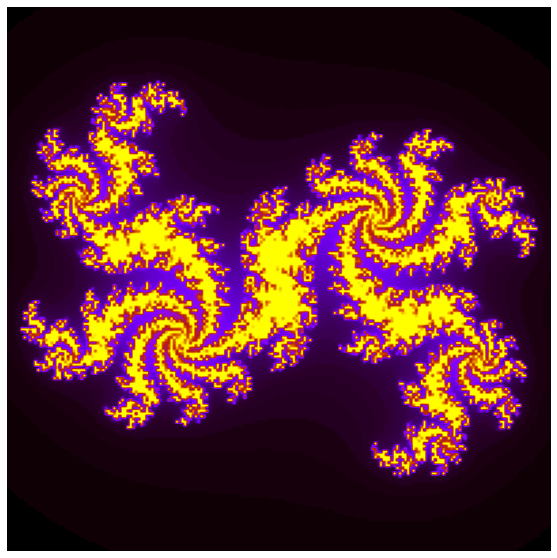

In [58]:
t0 = time.time()
python_run()
runtime = time.time() - t0
mandel_timings.append(runtime)
print(mandel_timings)


In [59]:
kernel_njit = njit(kernel)

def compute_mandel_njit(cr, ci, N, bound, radius=1000.):
    mandel = np.empty((N, N), dtype=np.int_)
    grid_x = np.linspace(-bound, bound, N)

    for i, x in enumerate(grid_x):
        for j, y in enumerate(grid_x):
            mandel[i,j] = kernel_njit(x, y, cr, ci, radius, N)
    return mandel


def njit_run():
    kwargs = dict(cr=0.3852, ci=-0.2026,
              N=200,
              bound=1.2)
    print("Using njit kernel")
    mandel_func = compute_mandel_njit      
    mandel_set = mandel_func(**kwargs)
    
    plot_mandel(mandel_set)


Using njit kernel
Using njit kernel
[1.6563801765441895, 0.05070614814758301]


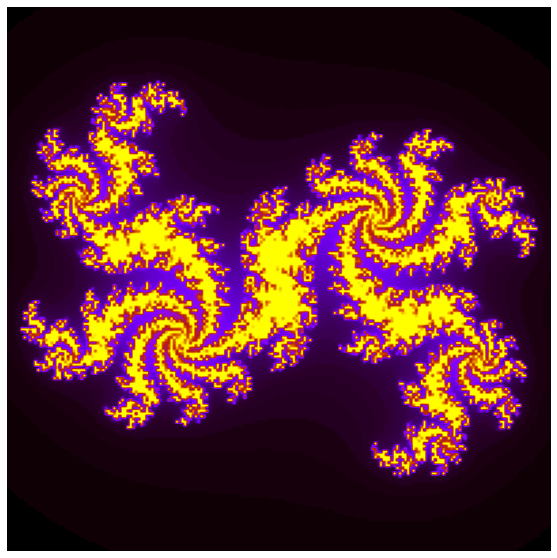

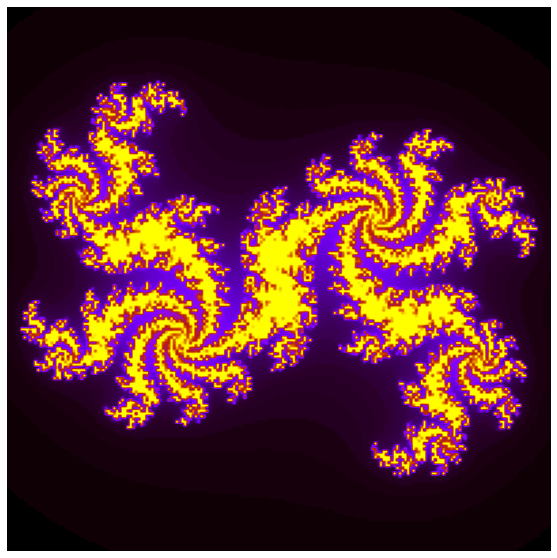

In [60]:
# compilation run
njit_run()

t0 = time.time()
njit_run()
runtime = time.time() - t0
mandel_timings.append(runtime)
print(mandel_timings)

In [61]:
compute_mandel_njit_jit = njit()(compute_mandel_njit)

def njit_njit_run():
    kwargs = dict(cr=0.3852, ci=-0.2026,
              N=200,
              bound=1.2)
    print("Using njit kernel and njit compute")
    mandel_func = compute_mandel_njit_jit      
    mandel_set = mandel_func(**kwargs)
    
    
    plot_mandel(mandel_set)

Using njit kernel and njit compute


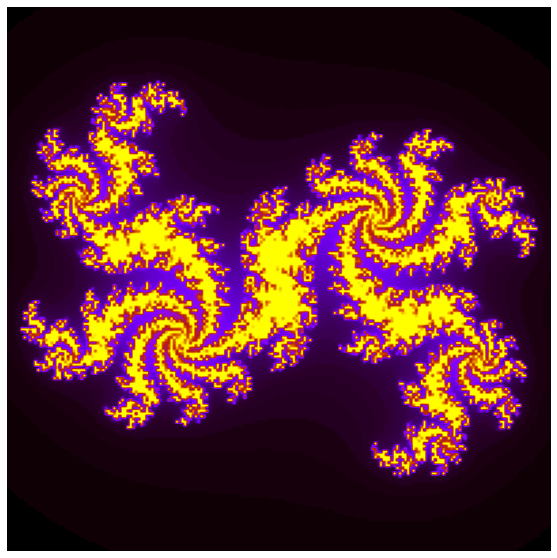

In [62]:
# Purposeful Error - go back and changed everywhere and re run timings 
njit_njit_run()

Using njit kernel and njit compute
[1.6563801765441895, 0.05070614814758301, 0.03362774848937988]


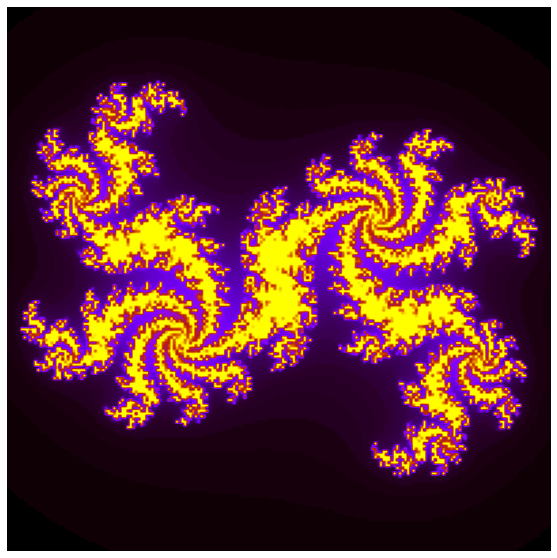

In [63]:
t0 = time.time()
njit_njit_run()
runtime = time.time() - t0
mandel_timings.append(runtime)
print(mandel_timings)

In [67]:
print(mandel_timings)
print("")
print("Speed up using njit on kernel function")
print(round(mandel_timings[0]/mandel_timings[1]))
print("Speed up using njit on kernel function and compute function")
print(round(mandel_timings[0]/mandel_timings[2]))


[1.6563801765441895, 0.05070614814758301, 0.03362774848937988]

Speed up using njit on kernel function
33
Speed up using njit on kernel function and compute function
49


***
# <center> `Cache=True` <center> 

In [6]:
#ctrl and / for group commenting/uncommenting


In [3]:
def is_prime(n):
    if n <= 1:
        raise ArithmeticError('n <= 1')
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False

    return True

In [4]:
is_prime_njit = njit()(is_prime)
is_prime_njit_cached = njit(cache=True)(is_prime)

In [5]:
numbers = np.random.randint(2, 100000, size=1000)

In [6]:
print ("Not cached including compilation")
%time p1 = [is_prime_njit(x) for x in numbers]
print("")
print ("Not cached")
%time p1 = [is_prime_njit(x) for x in numbers]
print ("")
print("Cached including compilation")
%time p2 = [is_prime_njit_cached(x) for x in numbers]
print ("")
print("Cached")
%time p2 = [is_prime_njit_cached(x) for x in numbers]
print ("")

Not cached including compilation
CPU times: user 117 ms, sys: 11.7 ms, total: 128 ms
Wall time: 134 ms

Not cached
CPU times: user 0 ns, sys: 381 µs, total: 381 µs
Wall time: 386 µs

Cached including compilation
CPU times: user 2.84 ms, sys: 1.95 ms, total: 4.79 ms
Wall time: 11.8 ms

Cached
CPU times: user 378 µs, sys: 0 ns, total: 378 µs
Wall time: 382 µs



To show `cache` working need to restart the kernel and reload the modules, functions and variables. **Not in this case** 

In [7]:
import numpy as np

import math
import time

import numba
from numba import jit, njit

def is_prime(n):
    if n <= 1:
        raise ArithmeticError('n <= 1')
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False

    return True

is_prime_njit = njit()(is_prime)
is_prime_njit_cached = njit(cache=True)(is_prime)

numbers = np.random.randint(2, 100000, size=1000)

In [9]:
print("Cached including compilation")
%time p2 = [is_prime_njit_cached(x) for x in numbers]
print ("")
print("Cached")
%time p2 = [is_prime_njit_cached(x) for x in numbers]
print ("")

Cached including compilation
CPU times: user 404 µs, sys: 0 ns, total: 404 µs
Wall time: 409 µs

Cached
CPU times: user 414 µs, sys: 0 ns, total: 414 µs
Wall time: 390 µs



* The point of using `cache=True` is to avoid repeating the compile time of large and complex functions at each run of a script. In this example the function is simple and the time saving is limited but for a script with a number of more complex functions, using cache can significantly reduce the run-time.

***
# <center> Eager Compilation using function signatures <center> 

In [10]:
# order them from smaller precision to higher ie int32, int64, float32, float64
is_prime_eager = njit(['boolean(int32)','boolean(int64)' ])(is_prime)
is_prime_njit = njit()(is_prime)

In [11]:
numbers = np.random.randint(2, 100000, dtype=np.int32, size=10000)

In [12]:
print("Just njit including compilation")
%time p1 = [is_prime_njit(x) for x in numbers]
print("")
print("Just njit")
%time p1 = [is_prime_njit(x) for x in numbers]
print("")
print("Eager including compilation")
%time p2 = [is_prime_eager(x) for x in numbers]
print("")
print("Eager")
%time p2 = [is_prime_eager(x) for x in numbers]

Just njit including compilation
CPU times: user 97.2 ms, sys: 2.19 ms, total: 99.4 ms
Wall time: 100 ms

Just njit
CPU times: user 3.6 ms, sys: 0 ns, total: 3.6 ms
Wall time: 3.48 ms

Eager including compilation
CPU times: user 3.61 ms, sys: 0 ns, total: 3.61 ms
Wall time: 3.57 ms

Eager
CPU times: user 3.42 ms, sys: 367 µs, total: 3.79 ms
Wall time: 3.64 ms


In [13]:
print("Just njit")
%time p1 = [is_prime_njit(x) for x in numbers.astype(np.int64)]
print("")
print("Eager")
%time p2 = [is_prime_eager(x) for x in numbers.astype(np.int64)]

# change to np.float64 in both

Just njit
CPU times: user 88.5 ms, sys: 4.74 ms, total: 93.3 ms
Wall time: 91.3 ms

Eager
CPU times: user 2.94 ms, sys: 952 µs, total: 3.9 ms
Wall time: 3.7 ms


***
# <center> `fastmath=True` <center> 

In [14]:
is_prime_njit_fmath = njit(fastmath=True)(is_prime)

In [15]:
%time p1 = [is_prime_njit(x) for x in numbers]
print("")
print("Fastmath including compilation")
%time p2 = [is_prime_njit_fmath(x) for x in numbers]
print("")
print("Fastmath compilation")
%time p2 = [is_prime_njit_fmath(x) for x in numbers]

CPU times: user 3.75 ms, sys: 0 ns, total: 3.75 ms
Wall time: 3.75 ms

Fastmath including compilation
CPU times: user 96 ms, sys: 477 µs, total: 96.5 ms
Wall time: 93.9 ms

Fastmath compilation
CPU times: user 3.5 ms, sys: 0 ns, total: 3.5 ms
Wall time: 3.41 ms




Enables the use of otherwise unsafe floating point transforms

Meaning it's possible to relax some numerical rigour with view of gaining additional performance.

For example assume the arguments and result are not NaN or Infs.

See here 

[llvm docs](https://llvm.org/docs/LangRef.html#fast-math-flags)





****
# <center> [Exercise 2 ~ 10 mins](exercise/02-Numba-Exercises.ipynb)


***
# <center>  `parallel=True`<center> 

### Parallelising Pi monte_carlo
Add `parallel=True` to use multi-core CPU via threading 

Use `numba.prange` with `parallel=True` **if you have for loops**

With the default `parallel=False`,
`numba.prange` is the same as `range`.


Default number of threads (max) = `numba.config.NUMBA_NUM_THREADS`


In [16]:
max_threads = numba.config.NUMBA_NUM_THREADS
print(max_threads)

24


In [17]:
def pi_montecarlo_python(n):
    in_circle = 0
    for i in range(n):
        x, y = np.random.random(), np.random.random()
        if x ** 2 + y ** 2 <= 1.0:
            in_circle += 1
        
    return 4.0 * in_circle / n

def pi_montecarlo_numpy(n):
    in_circle = 0
    x = np.random.random(n)
    y = np.random.random(n)
    in_circle = np.sum((x ** 2 + y ** 2) <= 1.0)
        
    return 4.0 * in_circle / n


n = 1000000





In [18]:
pi_montecarlo_python_njit = njit()(pi_montecarlo_python)

pi_montecarlo_numpy_njit = njit()(pi_montecarlo_numpy)

pi_montecarlo_python_parallel = njit(parallel=True)(pi_montecarlo_python)

pi_montecarlo_numpy_parallel = njit(parallel=True)(pi_montecarlo_numpy)

In [19]:
print('njit_python including compilation')
%time pi_montecarlo_python_njit(n)
print("")
print('njit_python')
%time pi_montecarlo_python_njit(n)
print("")
print('njit_numpy including compilation')
%time pi_montecarlo_numpy_njit(n)
print("")
print('njit_numpy')
%time pi_montecarlo_numpy_njit(n)
print("")
print('njit_python_parallel including compilation')
%time pi_montecarlo_python_parallel(n)
print("")
print('njit_python_parallel')
%time pi_montecarlo_python_parallel(n)
print("")
print('njit_numpy_parallel including compilation')
%time pi_montecarlo_numpy_parallel(n)
print("")
print('njit_numpy_parallel')
%time pi_montecarlo_numpy_parallel(n)



# remember to go back and add prange



njit_python including compilation
CPU times: user 219 ms, sys: 0 ns, total: 219 ms
Wall time: 220 ms

njit_python
CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 10.2 ms

njit_numpy including compilation
CPU times: user 608 ms, sys: 16.7 ms, total: 625 ms
Wall time: 634 ms

njit_numpy
CPU times: user 21 ms, sys: 5.98 ms, total: 27 ms
Wall time: 27.2 ms

njit_python_parallel including compilation
CPU times: user 154 ms, sys: 3.96 ms, total: 158 ms
Wall time: 159 ms

njit_python_parallel
CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 10 ms

njit_numpy_parallel including compilation


/ichec/home/users/course00/numba/lib/python3.7/site-packages/numba/core/typed_passes.py:330: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../../../tmp/ipykernel_15230/2330191652.py", line 1:
<source missing, REPL/exec in use?>

  state.func_ir.loc))
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 1.19 s, sys: 124 ms, total: 1.31 s
Wall time: 1.37 s

njit_numpy_parallel
CPU times: user 25 ms, sys: 4.47 ms, total: 29.5 ms
Wall time: 1.9 ms


3.14286

In [20]:
numba.set_num_threads(2)

print('njit_python')
%time pi_montecarlo_python_njit(n)
print("")
print('njit_numpy')
%time pi_montecarlo_numpy_njit(n)
print("")
print('njit_python_parallel')
%time pi_montecarlo_python_parallel(n)
print("")
print('njit_numpy_parallel')
%time pi_montecarlo_numpy_parallel(n)

njit_python
CPU times: user 10.5 ms, sys: 66 µs, total: 10.6 ms
Wall time: 17.3 ms

njit_numpy
CPU times: user 15.2 ms, sys: 9.08 ms, total: 24.3 ms
Wall time: 23.4 ms

njit_python_parallel
CPU times: user 10 ms, sys: 831 µs, total: 10.8 ms
Wall time: 10.4 ms

njit_numpy_parallel
CPU times: user 18.4 ms, sys: 225 µs, total: 18.6 ms
Wall time: 14.5 ms


3.139804

In [21]:
pi_montecarlo_numpy_parallel.parallel_diagnostics(level=1)

#Control the level diagnostic information - value between 1 and 4 (1 being least verbose and 4 most.)

# look at python version with prange & without

 
 Parallel Accelerator Optimizing:  Function pi_montecarlo_numpy, 
/tmp/ipykernel_15230/2330191652.py (10)  


Parallel loop listing for  Function pi_montecarlo_numpy, /tmp/ipykernel_15230/2330191652.py (10) 
-------------------------------------------------------|loop #ID
def pi_montecarlo_numpy(n):                            | 
    in_circle = 0                                      | 
    x = np.random.random(n)----------------------------| #0
    y = np.random.random(n)----------------------------| #1
    in_circle = np.sum((x ** 2 + y ** 2) <= 1.0)-------| #2, 3
                                                       | 
    return 4.0 * in_circle / n                         | 
------------------------------ After Optimisation ------------------------------
Parallel region 0:
+--0 (parallel, fused with loop(s): 1, 2, 3)


 
Parallel region 0 (loop #0) had 3 loop(s) fused.
--------------------------------------------------------------------------------
-------------------------------

***
# <center>  Creating `ufuncs` using `numba.vectorize` <center> 

* A universal function (or ufunc for short) is a function that operates on ndarrays in an element-by-element fashion. Is a “vectorized” wrapper for a function. For example `np.add()` is a ufunc.
* two types of ufuncs:
    * Those which operate on scalars, **ufuncs** (see `@vectorize` below).
    * Those which operate on higher dimensional arrays and scalars, these are “generalized universal functions” or **gufuncs** (`@guvectorize`).


* The `@vectorize` decorator allows Python functions taking scalar input arguments to be used as NumPy ufuncs. Creating a traditional NumPy ufunc involves writing some C code - Numba makes this easy. This decorator means Numba can compile a pure Python function into a ufunc that operates over NumPy arrays as fast as traditional ufuncs written in C.

The vectorize() decorator has two modes of operation:

**Eager**, or decoration-time, compilation: If you pass one or more type signatures to the decorator, you will be building a Numpy universal function (ufunc).

- pass in the form `'output_type1(input_type1)' , 'output_type2(input_type12)' etc`

**Lazy**, or call-time, compilation: When not given any signatures, the decorator will give you a Numba dynamic universal function (DUFunc) that dynamically compiles a new kernel when called with a previously unsupported input type.


If you pass several signatures, beware that you have to pass most specific signatures before least specific ones (e.g., single-precision floats before double-precision floats), otherwise type-based dispatching will not work as expected. EG (int32,int64,float32,float64)


Here is a very simple example:



In [22]:
numba.set_num_threads(max_threads)

def numpy_sin(a, b):
    return np.sin(a) + np.sin(b) + np.cos(a) - np.cos(b) + (np.sin(a))**2


numpy_sin_vec = numba.vectorize(['int64(int64, int64)','float64(float64, float64)'])(numpy_sin)

numpy_sin_vec_par = numba.vectorize(['int64(int64, int64)','float64(float64, float64)'],target='parallel')(numpy_sin)




In [23]:
x = np.random.randint(0, 100, size=90000)
y = np.random.randint(0, 100, size=90000)

print("Just numpy")
%time _ = numpy_sin(x, y)
print("")
print("Vectorised")
%time _ = numpy_sin_vec(x, y)
print("")
print("Vectorised & parallelised")
%time _ = numpy_sin_vec_par(x, y)

Just numpy
CPU times: user 17.3 ms, sys: 4.08 ms, total: 21.4 ms
Wall time: 20.1 ms

Vectorised
CPU times: user 14.9 ms, sys: 0 ns, total: 14.9 ms
Wall time: 14.5 ms

Vectorised & parallelised
CPU times: user 86.5 ms, sys: 18.7 ms, total: 105 ms
Wall time: 8.72 ms


****
# <center> [Exercise 3 ~ 5mins](exercise/02-Numba-Exercises.ipynb)

*****
***
# summary
- Numba is very useful for speeding up Python loops
- The two modes - reccomennd `nopython=True`, `njit`
- `cache=True` for reducing compilation time
- eager compilations also reduces compilation and calculation time 
- `fastmath = True`
- Achieve parallelism very easily - automatic with NumPy, and for Python  `for` loops use `prange`.

# Numba limitations 
- Numba only compiles individual functions not whole scripts
- Only supports a subset of Python and Numpy
    - But thats changing fast.
    - Keep an eye out for new versions to stay up to date



## Give Big Exercise a go

# <center> [Big Exercise](exercise/02-Numba-Exercises.ipynb)